# Basic tutorial on building speaker identification system using Pytorch

* Presenter: Ayush Agarwal
* Date: 09/07/2021

### Installation of libraries to be used

In [ ]:
pip install torch librosa pysptk pyworld 

### Importing installed libraries and packages

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import os

import scipy.io as sio

import librosa #taking speech files as input#
import matplotlib.pyplot as plt # ploting# 
import numpy as np #mathematical operations#
import random
import pysptk  # signal processing toolkit #
import pyworld # signal processing toolkit #
from sklearn.model_selection import train_test_split 

import soundfile

### Speaker identification(SID)

#### Basic flow of SID

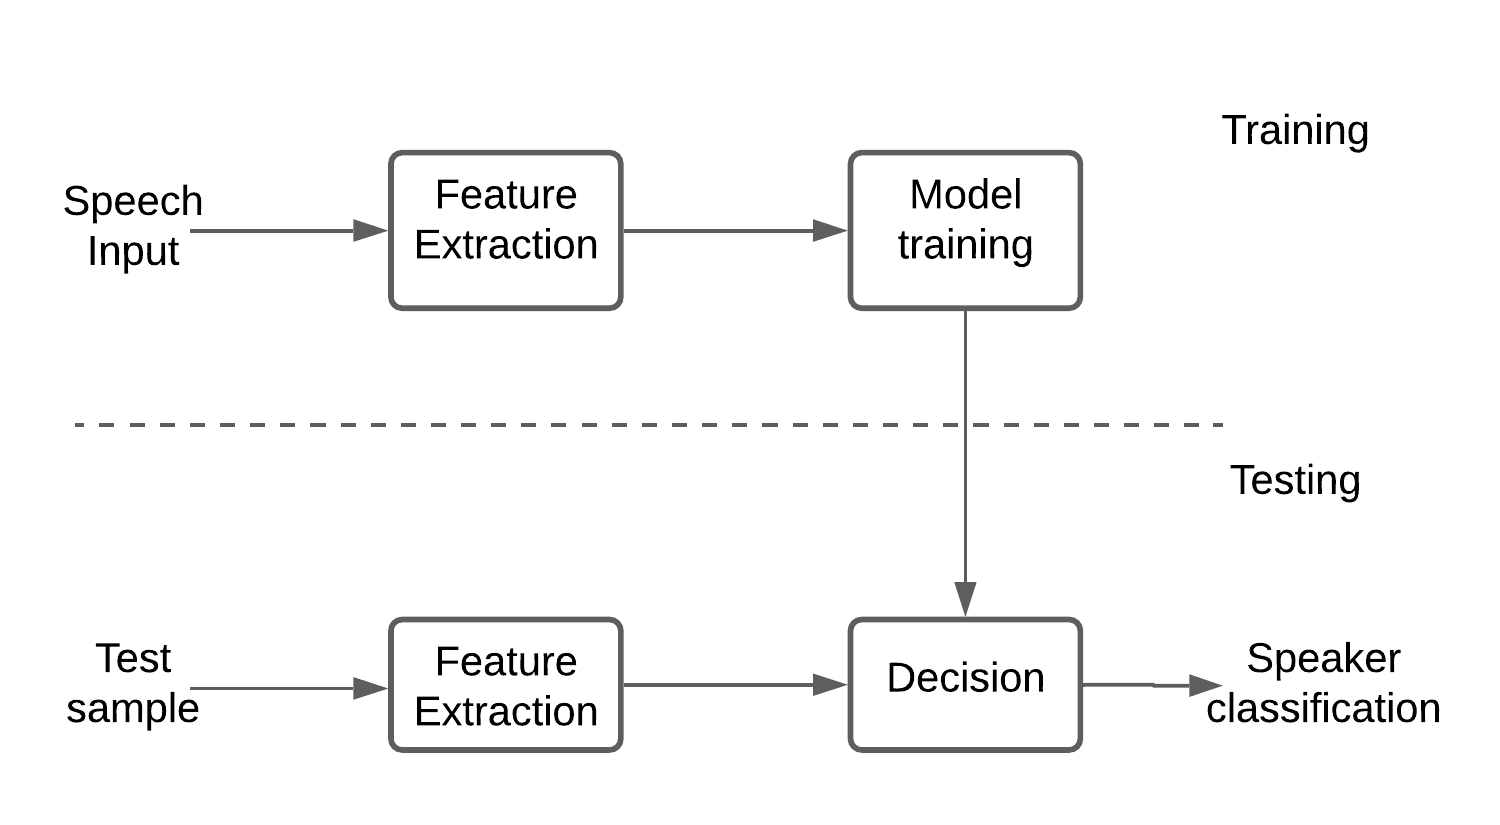

## SID using pytorch

* Feature extraction
* Spliting training and validation data
* Dataset and Dataloaders
* Modelling using feed forward neural network (FFNN)
    * Weight initialization, optimizer and loss function
    * Training and validation
    * Checkpoint for the model
* Testing
    * Load saved checkpoint
    * Test for new input

### Feature extraction

* Speech has lots of information which may be redundant. So, depending upon the application we need to extract those information that are useful for the task we perform.

* For speaker identification (SID) application we need to use those features that are unique for a speaker.

* [Mel frequency cepstral coeffients (MFCCs)](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) are used as it contains speaker specific feature for SID task.



In [34]:
class feature_extraction:
    def __init__(self,folderPath="/home/sysad/Documents/Day_4_SID/Dataset",
                 spk_folder="Train_Folder"):
        
        ## GET THE SPEECH FILES FROM THE DATASET FOLDER HIERARCHY
        
        ## Dataset --> Train_Folder --> Speakers (1002, 1011,...) --> Speech files (.wav files)
        
        
        
        self.folderPath = folderPath
        self.spk_folder = spk_folder
        
        self.spk_folder_path = os.path.join(self.folderPath, self.spk_folder)
        self.spk_names = os.listdir(self.spk_folder_path)
        self.spk_names.sort()
        self.spk_names = np.asarray(self.spk_names)
 
        print(self.spk_names)
        print("Speaker path is:", self.spk_folder_path)
        
        ## Dataset --> Train_Folder --> Speakers (1002, 1011,...) -->
        
        ##### Initialization of variables #####
        self.spk_index=[]
        self.file_features = np.zeros((1,25))
        self.labels = np.zeros((1,1))        
        #######################################
        
        for speakers in range(len(self.spk_names)):
            self.speaker = self.spk_names[speakers]
            self.spk_file_path = os.path.join(self.folderPath, self.spk_folder, self.speaker) 
            self.spk_file = os.listdir(self.spk_file_path)
            self.spk_file.sort()

            
            ## Dataset --> Train_Folder --> Speakers (1002, 1011,...) --> Speech files (.wav files)
            
            for i in range(len(self.spk_file)):
                wav_path = os.path.join(self.folderPath, self.spk_folder, self.speaker, self.spk_file[i])
                print("Label for ",self.spk_file[i]," is ",speakers)
                
                self.spk_index.append(self.spk_file[i][0:4])
            
                ########## MFCC feature extraction from speech utterance #############
                frame_period = 5
                fftlen = pyworld.get_cheaptrick_fft_size(8000)
                alpha = pysptk.util.mcepalpha(8000)
                order = 24
        
                speech, fs = librosa.load(wav_path, sr=8000)
                speech = speech.astype(np.float64)
                f0, time_axis = pyworld.dio(speech, fs, frame_period=frame_period)
                f0 = pyworld.stonemask(speech, f0, time_axis, fs)
                spectrogram = pyworld.cheaptrick(speech, f0, time_axis, fs)
                mfcc = pysptk.sp2mc(spectrogram, order=order, alpha= alpha)
                ######################################################################
                
                file_feats = np.asmatrix(mfcc[:,:])
               
                self.file_features = np.concatenate((self.file_features, file_feats),axis=0)
                
                self.labels = np.concatenate( (self.labels,np.ones((len(file_feats),1))*speakers), axis=0)
#                 print(len(self.labels))
                
                

        self.file_features = self.file_features[1:,:]
        self.labels = self.labels[1:,:]
        
        print("Size of features are: ", np.shape(self.file_features))
        print("Size of labels are: ", np.shape(self.labels))

In [35]:
a = feature_extraction()

['1002' '1011' '2029' '2030' '2033']
Speaker path is: /home/sysad/Documents/IEEE_virtual_summer_school/Dataset/Train_Folder
Label for  1002_AH01OENC.wav  is  0
Label for  1011_AH01OENC.wav  is  1
Label for  2029_AH01OENC.wav  is  2
Label for  2029_BH01OENC.wav  is  2
Label for  2030_AH01OENC.wav  is  3
Label for  2030_BH01OENC.wav  is  3
Label for  2033_AH01OENC.wav  is  4
Label for  2033_BH01OENC.wav  is  4
Size of features are:  (120734, 25)
Size of labels are:  (120734, 1)


In [5]:
data = a.file_features
label= a.labels

### Spliting the dataset into training and validation set

In [6]:
X_train, X_valid, Y_train, Y_valid = train_test_split(data, label, test_size = 0.1, random_state=1,shuffle=True)

### Datasets and Dataloaders

* **Dataset** makes the extracted features ready so that data gets easily coupled to the deep learning network. Dataset stores the samples and their corresponding labels.
* **DataLoader** helps to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting and enables multiprocessing to speed up data retrival.

In [7]:
#%% used for dataset preparation
class Dataset(Data.Dataset):
    def __init__(self, feat=None, label=None):
        super(Dataset, self).__init__()
        self.feat = feat
        self.label = label
        print(np.shape(feat))
        print(np.shape(label))
        
    def __len__(self):

        
        return self.feat.shape[0]
        
    def __getitem__(self, index):
        vector = self.feat[index]
        lab=self.label[index]

        feat = torch.from_numpy(vector)  ## to use torch we need to convert numpy array/matrix to tensor
        label= torch.from_numpy(lab)
        return feat, label


In [8]:
data_train=Dataset(feat=X_train,label=Y_train)
train_loader = Data.DataLoader(data_train, shuffle=True, batch_size=10, pin_memory=True, num_workers=4)
data_valid=Dataset(feat=X_valid,label=Y_valid)
valid_loader = Data.DataLoader(data_valid, shuffle=True, batch_size=10, pin_memory=True, num_workers=4)

(108660, 25)
(108660, 1)
(12074, 25)
(12074, 1)


### Feed forward neural network

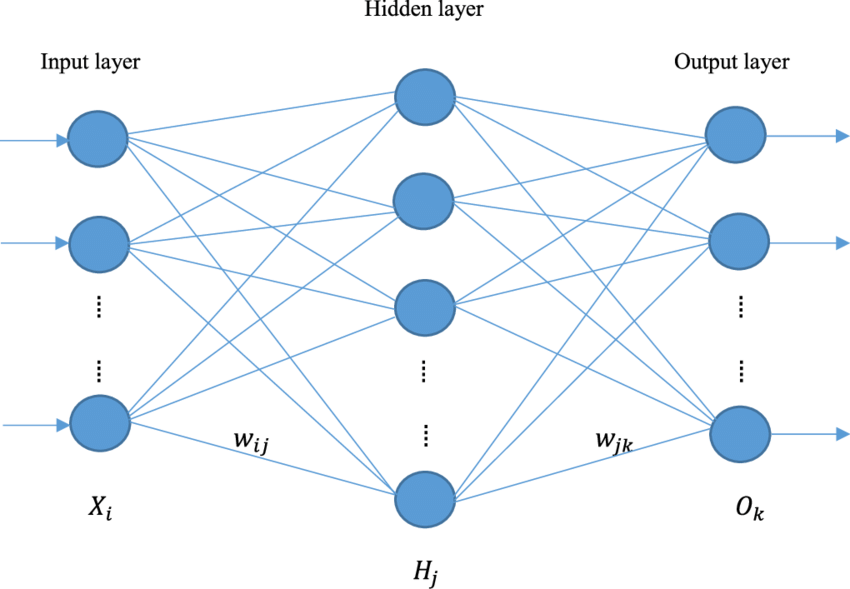

[Ref](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FTopology-of-a-multilayer-feed-forward-neural-network-used-for-classification_fig2_333804204&psig=AOvVaw0nRl3AwGbnRt7Z12oDWqi3&ust=1625905126924000&source=images&cd=vfe&ved=0CAoQjRxqFwoTCLiZqOjG1fECFQAAAAAdAAAAABAD)

In [9]:
class dnn_ffnn(nn.Module):

    def __init__(self,):
        super(dnn_ffnn, self).__init__()
        self.linear1 = nn.Linear(25, 128) # IL - H1   # [num, 39] -> [num, 1024]
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 5)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        #x = F.sigmoid(self.linear3(x))
        x=self.linear3(x)
        return x


#### Weights initialization

* torch.nn.init.xavier_normal_(layer) :  Initialize weights from normal distribution.
* torch.nn.init.xavier_normal_(layer) :  Initialize weights from uniform distribution.

In [10]:
# for weight initialization
def initialize_weights(model_layer):
    if type(model_layer) == nn.Linear:
        torch.nn.init.xavier_normal_(model_layer.weight)

In [11]:
# for calling model       
model=dnn_ffnn() 

In [12]:
model.apply(initialize_weights)

dnn_ffnn(
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=5, bias=True)
)

#### Optimizer and loss function

* Optimizers are algorithms used to learn weights of the neural network by decreasing the loss.
* Gradient descent is the basis optimizer but it gets stuck in local minima for non-convex.
* There are various optimizers proposed like Adagrad, RMSProp, Adam, etc. Adam is the most used optimizer.
---------------------------------------------------------------------------------------------------------
* Loss function tells us how close we are to the actual target. Depending upon the loss we update the paramters.
* **Loss function:**
    * Mean square loss: Used when we learn the mapping function (Regression)
    * Cross entropy loss: Used when we learn the decision boundary (Classification)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()

#### Training and saving checkpoint

In [14]:
def train(epoch):
    model.train()
    running_loss = 0
    #running_corr = 0
    for batch_id, batch in enumerate(train_loader):
        optimizer.zero_grad()

        train_data, train_labels = batch[0], batch[1] ## batch is tuple which has features and it's labels
        
        train_data = train_data.to(dtype=torch.float) ## Make sure to convert the datatype to float.
        train_labels = train_labels.to(dtype=torch.float)
        
        output = model(train_data)                    ## Training data is passed to the model
        output = output.reshape(len(batch[1]),5)

        train_labels = torch.squeeze(train_labels)
        train_labels = train_labels.type(torch.LongTensor)


        loss = criterion1(output, train_labels)      ## Cross entropy loss to compute the loss.
        loss.backward()                              ## Backpropagation
        
        optimizer.step()
        
        loss = criterion1(output, train_labels)
        
        running_loss+=loss.data

    loss = running_loss/len(train_loader.dataset)
    
    print(f'Total Training Loss: {loss} Epochs: {epoch}')
    
    valid_running_loss = 0
    for valid_batch_id, valid_batch in enumerate(valid_loader):

        valid_feat, valid_lab = valid_batch[0], valid_batch[1]

        valid_feat = valid_feat.to(dtype=torch.float)
        valid_lab = valid_lab.to(dtype=torch.float)
        
        op_val=model(valid_feat)    
        
        op_val = op_val.reshape(len(valid_batch[1]),5)
        valid_lab = torch.squeeze(valid_lab)
        valid_lab = valid_lab.type(torch.LongTensor)
    
        valid_loss=criterion1(op_val, valid_lab)
        valid_running_loss +=valid_loss.data
        
    valid_loss=valid_running_loss/len(valid_loader.dataset)

    print(f'Total valid Loss: {valid_loss}  Epochs: {epoch}')
    # Saving the model
    checkpoint_dict = {
                    'batch_id':batch_id,
                    'epoch' : epoch,
                    'model_state' : model.state_dict(),
                    'optim_state' : optimizer.state_dict(),
                    }
    torch.save(checkpoint_dict ,'/home/sysad/Documents/Day_4_SID/model_checkpoint.pth')
    return loss,valid_loss

In [15]:
total_epochs = 15
tr_loss=np.zeros((total_epochs,1),dtype=float)

val_loss=np.zeros((total_epochs,1),dtype=float)

for epoch in range(0, total_epochs):
    [tr_loss[epoch],val_loss[epoch]]=train(epoch)

Total Training Loss: 0.09403841942548752 Epochs: 0
Total valid Loss: 0.09028424322605133  Epochs: 0
Total Training Loss: 0.08274803310632706 Epochs: 1
Total valid Loss: 0.08073510229587555  Epochs: 1
Total Training Loss: 0.08062952756881714 Epochs: 2
Total valid Loss: 0.08332249522209167  Epochs: 2
Total Training Loss: 0.07913501560688019 Epochs: 3
Total valid Loss: 0.08015687018632889  Epochs: 3
Total Training Loss: 0.07861878722906113 Epochs: 4
Total valid Loss: 0.07776501029729843  Epochs: 4
Total Training Loss: 0.07791511714458466 Epochs: 5
Total valid Loss: 0.07777807116508484  Epochs: 5
Total Training Loss: 0.07773071527481079 Epochs: 6
Total valid Loss: 0.0781521424651146  Epochs: 6
Total Training Loss: 0.07743006199598312 Epochs: 7
Total valid Loss: 0.07616336643695831  Epochs: 7
Total Training Loss: 0.07691497355699539 Epochs: 8
Total valid Loss: 0.0801108255982399  Epochs: 8
Total Training Loss: 0.0767013281583786 Epochs: 9
Total valid Loss: 0.0766814723610878  Epochs: 9
Tota

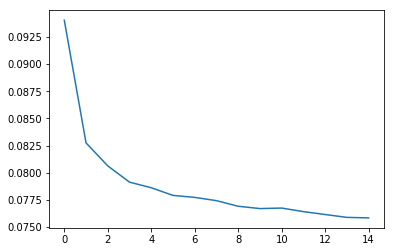

In [16]:
plt.plot(tr_loss)

### Testing

In [17]:

wav_path = '/home/sysad/Documents/IEEE_virtual_summer_school/Dataset/Test_Folder/1002/1002_AH01OENC_02.wav'

         
frame_period = 5
fftlen = pyworld.get_cheaptrick_fft_size(8000)
alpha = pysptk.util.mcepalpha(8000)
order = 24
        
speech, fs = librosa.load(wav_path, sr=8000)
speech = speech.astype(np.float64)
f0, time_axis = pyworld.dio(speech, fs, frame_period=frame_period)
f0 = pyworld.stonemask(speech, f0, time_axis, fs)
spectrogram = pyworld.cheaptrick(speech, f0, time_axis, fs)
mfcc = pysptk.sp2mc(spectrogram, order=order, alpha= alpha)
                
file_feats = np.asmatrix(mfcc[:,:])

In [18]:
print("Size of input test feature: ",np.shape(mfcc))

(5986, 25)

In [19]:
test_features = torch.from_numpy(mfcc)
test_features = test_features.to(dtype=torch.float)
test_features.shape

torch.Size([5986, 25])

In [20]:
model = dnn_ffnn()

checkpoint = torch.load('/home/sysad/Documents/IEEE_virtual_summer_school/model_checkpoint.pth')

epoch = checkpoint['epoch']
batch_id = checkpoint['batch_id']
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])

model.eval()

dnn_ffnn(
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=5, bias=True)
)

In [21]:
test_output = model(test_features)

In [22]:
test_output.shape

torch.Size([5986, 5])

In [24]:
indexes = torch.argmax(test_output, dim=1)
indexes

tensor([4, 0, 0,  ..., 0, 0, 0])

In [25]:
speaker = torch.mode(indexes,0)

In [39]:
speaker.values

tensor(0)

### Thankyou